In [1]:
import numpy as np
import pandas as pd

# Define x values (training set range)
x_values = np.linspace(-10, 10, 100)

# Define training functions (e.g., polynomial functions)
training_functions = {
    "f1": lambda x: 2 * x + 3,
    "f2": lambda x: x**2 - 4*x + 5,
    "f3": lambda x: np.sin(x) * x,
    "f4": lambda x: np.exp(-x/5) * np.cos(x)
}

# Generate training data with noise
training_data = {"x": x_values}
for name, func in training_functions.items():
    training_data[name] = func(x_values) + np.random.normal(0, 0.5, len(x_values))

# Convert to DataFrame and save
df_train = pd.DataFrame(training_data)
df_train.to_csv("training_data.csv", index=False)
print("Training data saved as training_data.csv")


Training data saved as training_data.csv


In [2]:
# Define x values for ideal functions (denser than training)
x_ideal = np.linspace(-10, 10, 200)

# Define ideal functions (closely related to training functions)
ideal_functions = {
    "i1": lambda x: 2 * x + 3,    # Exact match to f1
    "i2": lambda x: x**2 - 4*x + 5,  # Exact match to f2
    "i3": lambda x: np.sin(x) * x + 0.2*x,  # Slightly different from f3
    "i4": lambda x: np.exp(-x/5) * np.cos(x) + 0.1*x  # Slight variation from f4
}

# Generate ideal function data
ideal_data = {"x": x_ideal}
for name, func in ideal_functions.items():
    ideal_data[name] = func(x_ideal)

# Convert to DataFrame and save
df_ideal = pd.DataFrame(ideal_data)
df_ideal.to_csv("ideal_data.csv", index=False)
print("Ideal data saved as ideal_data.csv")



Ideal data saved as ideal_data.csv


In [3]:
# Randomly select test x values
x_test = np.random.uniform(-10, 10, 20)

# Generate test points using training functions with noise
test_data = {
    "x": x_test,
    "y": training_functions["f1"](x_test) + np.random.normal(0, 1.0, len(x_test))
}

# Convert to DataFrame and save
df_test = pd.DataFrame(test_data)
df_test.to_csv("test_data.csv", index=False)
print("Test data saved as test_data.csv")


Test data saved as test_data.csv


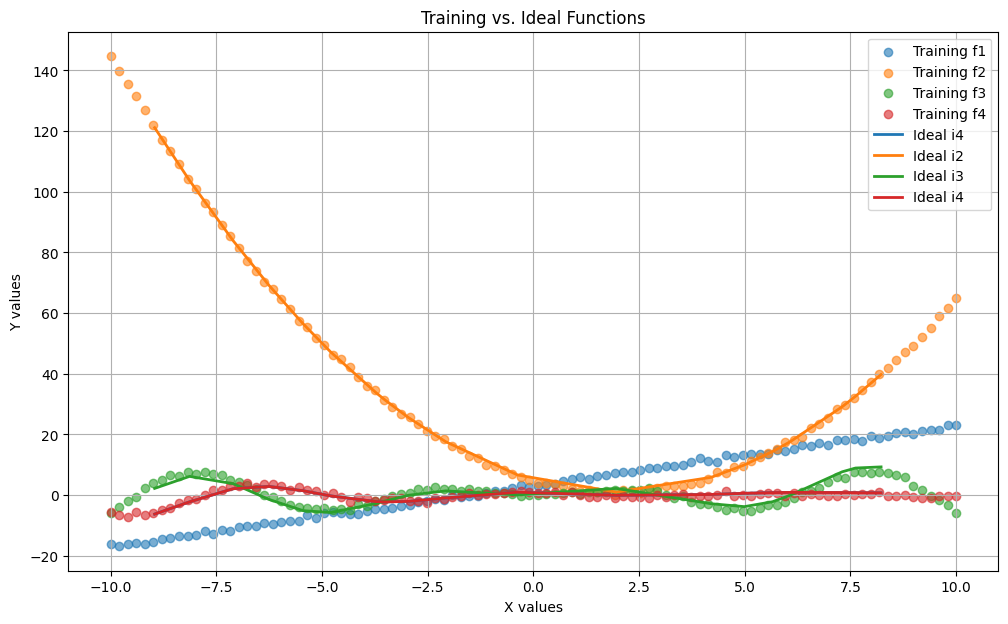

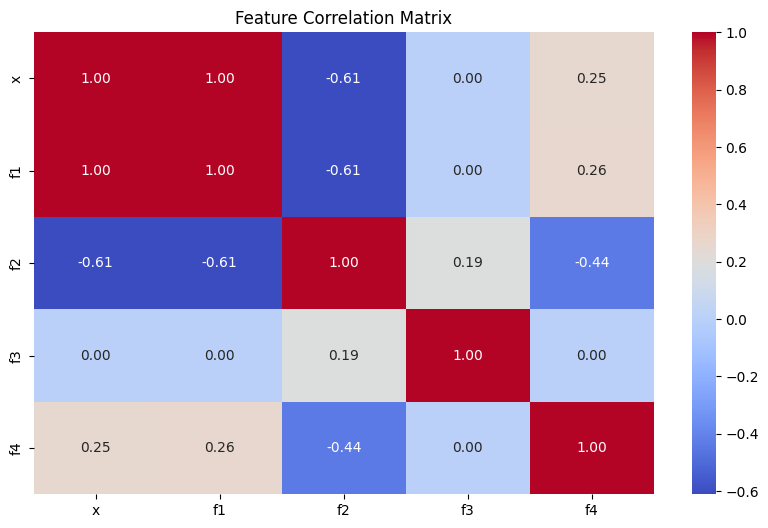

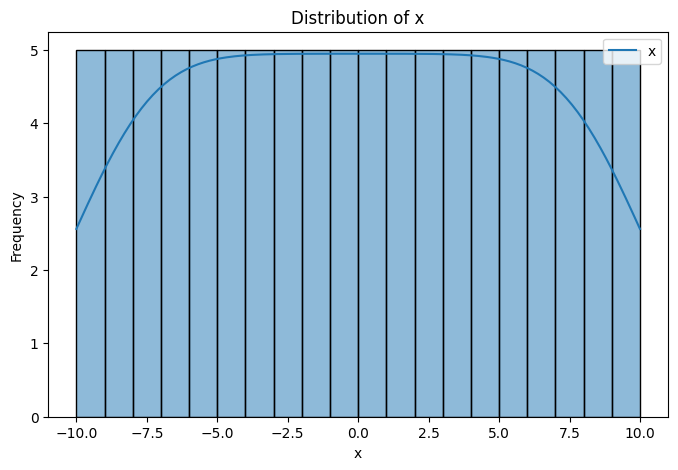

In [7]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
from scipy.optimize import curve_fit
import unittest
import seaborn as sns

class DatabaseManager:
    """Handles SQLite database operations using SQLAlchemy."""
    def __init__(self, db_name="data.db"):
        self.engine = create_engine(f'sqlite:///{db_name}')
        self.connection = self.engine.connect()
    
    def execute_query(self, query):
        try:
            self.connection.execute(query)
        except SQLAlchemyError as e:
            print("Database error:", e)
    
    def insert_dataframe(self, df, table_name):
        df.to_sql(table_name, self.engine, if_exists='replace', index=False)
    
    def fetch_dataframe(self, query):
        return pd.read_sql(query, self.engine)

class IdealFunctionFinder:
    """Finds the best ideal functions using least squares method."""
    def __init__(self, train_data, ideal_functions):
        self.train_data = train_data
        self.ideal_functions = ideal_functions
    
    def find_best_functions(self):
        best_funcs = []
        for col in self.train_data.columns[1:]:
            y_train = self.train_data[col]
            best_func = None
            min_error = float('inf')
            for ideal_col in self.ideal_functions.columns[1:]:
                y_ideal = self.ideal_functions[ideal_col]
                error = np.sum((y_train - y_ideal) ** 2)
                if error < min_error:
                    min_error = error
                    best_func = ideal_col
            best_funcs.append(best_func)
        return best_funcs

class DataVisualizer:
    """Handles data visualization using Matplotlib and Seaborn."""
    @staticmethod
    def plot_data(train_data, ideal_functions, test_data, mapping):
        plt.figure(figsize=(12, 7))

        # Plot training data
        for col in train_data.columns[1:]:
            plt.scatter(train_data["x"], train_data[col], label=f"Training {col}", alpha=0.6)

        # Plot ideal functions, ensuring x-values match
        for func in ideal_functions:
            if func in test_data.columns:
                sorted_test_data = test_data.sort_values(by="x")  # Sort to avoid dimension issues
                plt.plot(sorted_test_data["x"], sorted_test_data[func], label=f"Ideal {func}", linewidth=2)

        plt.legend(loc='best')
        plt.title("Training vs. Ideal Functions")
        plt.xlabel("X values")
        plt.ylabel("Y values")
        plt.grid(True)
        plt.show()
    
    @staticmethod
    def plot_correlation_matrix(df):
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Feature Correlation Matrix")
        plt.show()
    
    @staticmethod
    def plot_distribution(df, column):
        plt.figure(figsize=(8, 5))
        sns.histplot(df[column], kde=True, bins=20)
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.legend([column])
        plt.show()


# Load data
def load_data(file):
    return pd.read_csv(file)

# Main Execution
if __name__ == "__main__":
    db = DatabaseManager()
    
    # Load datasets
    train_data = load_data("training_data.csv")
    ideal_data = load_data("ideal_data.csv")
    test_data = load_data("test_data.csv")
    
    # Store in database
    db.insert_dataframe(train_data, "training_data")
    db.insert_dataframe(ideal_data, "ideal_functions")
    
    # Find best functions
    finder = IdealFunctionFinder(train_data, ideal_data)
    best_functions = finder.find_best_functions()
    
    # Store test data in database
    db.insert_dataframe(test_data, "test_data")
    
    # Map ideal functions to test data
    for i, func in enumerate(best_functions):
        if func in ideal_data.columns:
            # Ensure x values in test_data are within the range of x values in ideal_data
            x_min, x_max = ideal_data["x"].min(), ideal_data["x"].max()
            test_data_filtered = test_data[(test_data["x"] >= x_min) & (test_data["x"] <= x_max)]
            
            # Interpolate only for the filtered test_data
            test_data.loc[test_data_filtered.index, func] = np.interp(
                test_data_filtered["x"], ideal_data["x"], ideal_data[func]
            )
        else:
            print(f"Warning: Ideal function '{func}' not found in ideal_data columns.")

    # Visualize results
    DataVisualizer.plot_data(train_data, best_functions, test_data, best_functions)
    DataVisualizer.plot_correlation_matrix(train_data)
    DataVisualizer.plot_distribution(train_data, "x")

